In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
import os
import heapq

### Exercice 1 – Branch and Bound pour le problème du sac à dos 0/1
On vous demande dans cet exercice de programmer un algorithme de Branch & Bound pour résoudre le
problème du sac à dos 0/1. Vous testerez d’abord votre algorithme sur les données du cours, puis sur celles
utilisées lors de la séance précédente, et vous comparerez les temps de calcul. Vous pourrez également comparer
les 3 stratégies de branchement vues en cours.

Pistes : pour mon code, je me suis appuyé sur les deux classes suivantes (rien ne vous y oblige naturellement)

Avertissement : peu de chance que vous triomphiez de ce problème sans écrire au préalable un algorithme sur
papier

In [2]:
class TreeNode:
    def __init__(self, level, V, W, taken, upper_bound=None):
        self.level = level  # nível na árvore de busca
        self.V = V  # valor da solução corrente
        self.W = W  # peso da solução corrente
        self.taken = taken  # lista de índices dos itens na solução corrente
        self.upper_bound = upper_bound  # limite superior da solução (opcional)

    def __lt__(self, other):
        """ Define a ordem na heap para Best-First Search. 
        Se 'upper_bound' for None, assume prioridade 0. """
        return (self.upper_bound or 0) > (other.upper_bound or 0)  # Maior bound tem prioridade

In [3]:
class KPBB_BreadthFirst:
    def __init__(self, cap, values, weights): 
        self.capacity = cap
        self.values = values
        self.weights = weights
        self.unordered = [((v, w), i) for i, (v, w) in enumerate(zip(self.values, self.weights))]
        # Ordenação dos itens com base na relação valor/peso
        self.ordered = sorted([((v, w), i) for i, (v, w) in enumerate(zip(self.values, self.weights))], key=lambda tup: float(tup[0][0])/tup[0][1], reverse=True)
    
    def initialSolution(self):  # solução inicial com base na abordagem gananciosa
        W = self.capacity
        result = 0
        for item in self.ordered:
            if W - item[0][1] >= 0:  # se o item cabe na mochila
                result += item[0][0]
                W -= item[0][1]
        return result
    
    def UpperBound(self, node):  # cálculo do limite superior (Upper Bound)
        W = self.capacity - node.W  # peso restante
        result = node.V  # valor atual
        i = node.level + 1  # o próximo item a ser considerado
        
        while i < len(self.ordered) and self.ordered[i][0][1] <= W:
            W -= self.ordered[i][0][1]
            result += self.ordered[i][0][0]
            i += 1
        
        if i < len(self.ordered):
            result += self.ordered[i][0][0] * (W / self.ordered[i][0][1])  # fração do item

        return result
    
    def nodeEvaluation(self, index, node):  # avaliação do nó na árvore de busca
        if node.W <= self.capacity and node.V > self.bestValue:  # se o nó é válido e melhor que o melhor valor
            self.bestValue = node.V  # atualização do melhor valor
            self.bestTaken = node.taken  # atualização dos itens escolhidos
        # Se o valor da solução for possível, calculamos o limite superior
        if node.W <= self.capacity:
            upper_bound = self.UpperBound(node)
            return upper_bound
        else:
            return 0  # Se o peso for maior que a capacidade, o nó é inválido

    def solve(self):  # algoritmo de Branch & Bound
        root = TreeNode(-1, 0, 0, [])  # nó raiz
        queue = [root]  # fila de nós a serem explorados
        
        self.bestValue = 0  # melhor valor encontrado
        self.bestTaken = []  # lista de itens que compõem a melhor solução
        
        while queue:  # enquanto houver nós na fila
            node = queue.pop(0)  # retira o primeiro nó da fila

            if node.level < len(self.ordered) - 1:
                # Caso 1: Não incluir o item
                nodeLeft = TreeNode(node.level + 1, node.V, node.W, node.taken[:])
                upperLeft = self.nodeEvaluation(nodeLeft.level, nodeLeft)  # cálculo do upper bound
                
                if upperLeft > self.bestValue:  # se o upper bound for melhor que a melhor solução encontrada
                    queue.append(nodeLeft)

                # Caso 2: Incluir o item
                item = self.ordered[node.level + 1]
                nodeRight = TreeNode(node.level + 1, node.V + item[0][0], node.W + item[0][1], node.taken + [item[1]])
                upperRight = self.nodeEvaluation(nodeRight.level, nodeRight)  # cálculo do upper bound
                
                if upperRight > self.bestValue:  # se o upper bound for melhor que a melhor solução encontrada
                    queue.append(nodeRight)
        
        return self.bestValue, self.bestTaken


In [4]:
class KPBB_DepthFirst:
    def __init__(self, cap, values, weights): 
        self.capacity = cap
        self.values = values
        self.weights = weights
        self.unordered = [((v, w), i) for i, (v, w) in enumerate(zip(self.values, self.weights))]
        # Ordenação dos itens com base na relação valor/peso (ganância)
        self.ordered = sorted(self.unordered, key=lambda tup: float(tup[0][0]) / tup[0][1], reverse=True)
    
    def UpperBound(self, node):  # Cálculo do limite superior (Upper Bound)
        W = self.capacity - node.W  # Peso restante
        result = node.V  # Valor atual
        i = node.level + 1  # Próximo item a ser considerado
        
        while i < len(self.ordered) and self.ordered[i][0][1] <= W:
            W -= self.ordered[i][0][1]
            result += self.ordered[i][0][0]
            i += 1
        
        if i < len(self.ordered):
            result += self.ordered[i][0][0] * (W / self.ordered[i][0][1])  # Fração do item

        return result
    
    def nodeEvaluation(self, node):  # Avaliação do nó na árvore de busca
        if node.W <= self.capacity and node.V > self.bestValue:  # Se a solução for válida e melhor
            self.bestValue = node.V  # Atualiza o melhor valor
            self.bestTaken = node.taken  # Atualiza os itens escolhidos
        
        return self.UpperBound(node) if node.W <= self.capacity else 0  # Retorna upper bound

    def solve(self):  # Algoritmo de Branch & Bound (DFS)
        root = TreeNode(-1, 0, 0, [])  # Nó raiz
        stack = [root]  # Pilha de nós a serem explorados
        
        self.bestValue = 0  # Melhor valor encontrado
        self.bestTaken = []  # Itens da melhor solução
        
        while stack:  # Enquanto houver nós na pilha
            node = stack.pop()  # Remove o último nó adicionado (DFS)

            if node.level < len(self.ordered) - 1:
                # Caso 1: Incluir o item
                item = self.ordered[node.level + 1]
                nodeRight = TreeNode(node.level + 1, node.V + item[0][0], node.W + item[0][1], node.taken + [item[1]])
                upperRight = self.nodeEvaluation(nodeRight)

                if upperRight > self.bestValue:  # Se o upper bound for promissor
                    stack.append(nodeRight)  # Adiciona na pilha (DFS)

                # Caso 2: Não incluir o item
                nodeLeft = TreeNode(node.level + 1, node.V, node.W, node.taken[:])
                upperLeft = self.nodeEvaluation(nodeLeft)

                if upperLeft > self.bestValue:  # Se o upper bound for promissor
                    stack.append(nodeLeft)  # Adiciona na pilha (DFS)
        
        return self.bestValue, self.bestTaken

In [5]:
class KPBB_BestFirst:
    def __init__(self, cap, values, weights): 
        self.capacity = cap
        self.values = values
        self.weights = weights
        self.unordered = [((v, w), i) for i, (v, w) in enumerate(zip(self.values, self.weights))]
        self.ordered = sorted(self.unordered, key=lambda tup: float(tup[0][0])/tup[0][1], reverse=True)

    def UpperBound(self, node):
        W = self.capacity - node.W
        result = node.V
        i = node.level + 1
        
        while i < len(self.ordered) and self.ordered[i][0][1] <= W:
            W -= self.ordered[i][0][1]
            result += self.ordered[i][0][0]
            i += 1
        
        if i < len(self.ordered):
            result += self.ordered[i][0][0] * (W / self.ordered[i][0][1])

        return result

    def solve(self):
        root = TreeNode(-1, 0, 0, [], self.UpperBound(TreeNode(-1, 0, 0, [], 0)))  # Corrigido
        pq = []
        heapq.heappush(pq, root)

        self.bestValue = 0
        self.bestTaken = []

        while pq:
            node = heapq.heappop(pq)

            if node.upper_bound <= self.bestValue:
                continue  # Poda

            if node.level < len(self.ordered) - 1:
                # Caso 1: Incluir o item
                item = self.ordered[node.level + 1]
                nodeRight = TreeNode(node.level + 1, node.V + item[0][0], node.W + item[0][1], node.taken + [item[1]], self.UpperBound(node))
                
                if nodeRight.W <= self.capacity and nodeRight.V > self.bestValue:
                    self.bestValue = nodeRight.V
                    self.bestTaken = nodeRight.taken

                if nodeRight.upper_bound > self.bestValue:
                    heapq.heappush(pq, nodeRight)

                # Caso 2: Não incluir o item
                nodeLeft = TreeNode(node.level + 1, node.V, node.W, node.taken, self.UpperBound(node))
                
                if nodeLeft.upper_bound > self.bestValue:
                    heapq.heappush(pq, nodeLeft)

        return self.bestValue, self.bestTaken


In [6]:
def knapsack_BU(itens, W):
    W = int(W) 
    n = len(itens)  

    dp = [[0] * (W + 1) for _ in range(n + 1)] # Zero Matrix with (n+1) rows and (W+1) columns 

    for i in range(n): # for each item 
        ri, wi = itens[i] 
        wi = int(wi) 

        for x in range(W + 1):  # Cycle through all possible backpack capacities
            # If you don't get the current item
            dp[i + 1][x] = dp[i][x]

            #  Possibility 2: take the item 
            if wi <= x: # checks if it fits in the backpack
                dp[i + 1][x] = max(dp[i + 1][x], ri + dp[i][x - wi])

    # The maximum possible value is in the last cell of the matrix
    return dp[n][W]

In [8]:
path = "./instances_01_KP/low-dimensional/f8_l-d_kp_23_10000" 
dataset = np.loadtxt(path)

n = int(dataset[0][0])
cap = dataset[0][1]
itens = dataset[1:]

weights = dataset[1:,1]
values = dataset[1:,0]

print(weights)
print(values)

unordered = [((v, w), i) for i, (v, w) in enumerate(zip(values, weights))]
ordered = sorted([((v, w), i) for i, (v, w) in enumerate(zip(values, weights))], key = lambda tup: float(tup[0][0])/tup[0][1], reverse = True)

[983. 982. 981. 980. 979. 978. 488. 976. 972. 486. 486. 972. 972. 485.
 485. 969. 966. 483. 964. 963. 961. 958. 959.]
[981. 980. 979. 978. 977. 976. 487. 974. 970. 485. 485. 970. 970. 484.
 484. 976. 974. 482. 962. 961. 959. 958. 857.]


In [10]:
Knapsack = KPBB_BestFirst(cap, values, weights)
bestValue, bestTaken = Knapsack.solve()

print("Melhor valor encontrado:", bestValue)
print("Índices dos itens escolhidos:", bestTaken)

Melhor valor encontrado: 9767.0
Índices dos itens escolhidos: [16, 15, 0, 1, 2, 3, 4, 5, 6, 7, 9]


In [11]:
datasets = []
listing = os.listdir("./instances_01_KP/low-dimensional/")
my_array=np.zeros(shape=(0,5))
for infile in listing:
    path = "./instances_01_KP/low-dimensional/" + infile
    data = np.loadtxt(path)
    datasets.append(data)


=== Problem with 20 items and 879 capacity ===

=== Problem with 10 items and 269 capacity ===

=== Problem with 20 items and 878 capacity ===

=== Problem with 4 items and 20 capacity ===

=== Problem with 4 items and 11 capacity ===

=== Problem with 15 items and 375 capacity ===

=== Problem with 10 items and 60 capacity ===

=== Problem with 7 items and 50 capacity ===

=== Problem with 5 items and 80 capacity ===


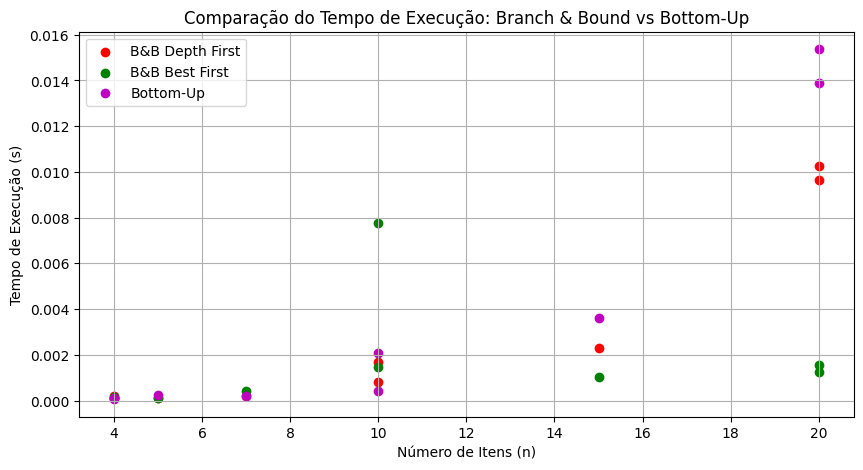

In [13]:
# Dicionário de métodos a serem comparados
methods = {
    # "B&B Breadth First": KPBB_BreadthFirst,
    "B&B Depth First": KPBB_DepthFirst,
    "B&B Best First": KPBB_BestFirst,
    "Bottom-Up": knapsack_BU  # Função, não classe
}

# Dicionário para armazenar tempos de execução
times = {method: [] for method in methods}
n_values = []

for dataset in datasets:
    n = dataset[0][0]  # Número de itens
    wmax = dataset[0][1]  # Capacidade da mochila
    itens = dataset[1:]
    weights = dataset[1:, 1]
    values = dataset[1:, 0]

    print(f"\n=== Problem with {n:.0f} items and {wmax:.0f} capacity ===")
    
    for method_name, method in methods.items():
        tic = time.perf_counter()

        if method_name == "Bottom-Up":
            bestValue = method(itens, wmax)  # Chamada da função direta
            bestTaken = None
        else:
            knapsack_solver = method(wmax, values, weights)
            bestValue, bestTaken = knapsack_solver.solve()

        toc = time.perf_counter()
        times[method_name].append(toc - tic)

    n_values.append(n)
    # print("Melhor valor encontrado:", bestValue)
    # print("Índices dos itens escolhidos:", bestTaken)

# Plotagem dos tempos de execução
plt.figure(figsize=(10, 5))
colors = ['r', 'g', 'm', 'b']  # Cores para os métodos

for (method_name, method_times), color in zip(times.items(), colors):
    plt.scatter(n_values, method_times, marker='o', linestyle='-', color=color, label=method_name)

plt.xlabel("Número de Itens (n)")
plt.ylabel("Tempo de Execução (s)")
plt.title("Comparação do Tempo de Execução: Branch & Bound vs Bottom-Up")
plt.legend()
plt.grid(True)
plt.show()


#### Large Scale

In [14]:
datasets = []
N_values = []
W_values = []
listing = os.listdir("./instances_01_KP/large_scale/")
my_array=np.zeros(shape=(0,5))
for infile in listing:
    path = os.path.join("./instances_01_KP/large_scale/", infile)
    
    parts = infile.split("_")
    N = int(parts[2])  # Terceiro elemento corresponde a N
    W = int(parts[3])  # Quarto elemento corresponde a W
    
    N_values.append(N)
    W_values.append(W)

    with open(path, "r") as f:
        lines = f.readlines()[:-1]  
    
    data = np.loadtxt(lines)
    datasets.append(data)

In [15]:
# Dicionário de métodos a serem comparados
methods = {
    "Bottom-Up": knapsack_BU,  # Função, não classe
    "B&B Best First": KPBB_BestFirst,
    "B&B Depth First": KPBB_DepthFirst,
    # "B&B Breadth First": KPBB_BreadthFirst
}

# Dicionário para armazenar tempos de execução
times = {method: [] for method in methods}
n_values = []

for dataset in datasets:
    n = dataset[0][0]  # Número de itens
    wmax = dataset[0][1]  # Capacidade da mochila
    itens = dataset[1:]
    weights = dataset[1:, 1]
    values = dataset[1:, 0]

    print(f"\n=== Problem with {n:.0f} items and {wmax:.0f} capacity ===")
    
    for method_name, method in methods.items():
        tic = time.perf_counter()

        if method_name == "Bottom-Up":
            bestValue = method(itens, wmax)  # Chamada da função direta
            bestTaken = None
        else:
            knapsack_solver = method(wmax, values, weights)
            bestValue, bestTaken = knapsack_solver.solve()

        toc = time.perf_counter()
        times[method_name].append(toc - tic)
        print(method_name, " = ", toc - tic)

    n_values.append(n)
    # print("Melhor valor encontrado:", bestValue)
    # print("Índices dos itens escolhidos:", bestTaken)

# Plotagem dos tempos de execução
plt.figure(figsize=(10, 5))
colors = ['r', 'g', 'm', 'b']  # Cores para os métodos

for (method_name, method_times), color in zip(times.items(), colors):
    plt.scatter(n_values, method_times, marker='o', linestyle='-', color=color, label=method_name)

plt.xlabel("Número de Itens (n)")
plt.ylabel("Tempo de Execução (s)")
plt.title("Comparação do Tempo de Execução: Branch & Bound vs Bottom-Up")
plt.legend()
plt.grid(True)
plt.show()


=== Problem with 10000 items and 49877 capacity ===
Bottom-Up  =  337.2801555999995


KeyboardInterrupt: 